In [1]:
import numpy as np
from TDD.TDD import Index,Ini_TDD,Clear_TDD,set_index_order,get_tdd,get_count
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs
from TDD.TDD_Q import reshape as reshape2
from TDD.TN import Tensor,TensorNetwork

from qiskit import QuantumCircuit
from sympy import *
from sympy.parsing.sympy_parser import parse_expr
from TDD.TDD import get_unique_table_num as gu1
from TDD.SymTDD.BDD import get_unique_table_num as gu2
from TDD.SymTDD.BDD import get_count as B_get_count

import time ,random, csv


In [2]:
from TDD.TDD import global_norm
# from TDD.TDD import TDD
# def global_norm(tdd):
#     node=tdd.node
#     weight=tdd.weight

#     if node.key==-1:
#         return tdd

#     h=weight
#     tdd_list=[]
#     for i in range (len(node.out_weight)):
#         tdd_list.append(TDD(node.successor[i]))
#         tdd_list[i].weight=h*node.out_weight[i]
#         tdd_list[i]=global_norm(tdd_list[i])

#     from TDD.TDD import normalize
#     new_tdd=normalize(node.key,tdd_list)
#     return new_tdd

In [3]:
def simulation(input_cir, Benchmark_Name=None,symbolic=True, unique_table_reset=True,output_file=None):
    if isinstance(input_cir,QuantumCircuit):
        cir=input_cir
    else:
        cir=QuantumCircuit.from_qasm_file(input_cir)
        if not Benchmark_Name:
            Benchmark_Name=input_cir
    tn,indices=cir_2_tn(cir)
    if symbolic:
        for k in range(tn.qubits_num):
            x_k='x'+str(k)
            xn_k='xn'+str(k)
            s=Symbol(x_k)
            ns=Symbol(xn_k)
            U=np.array([ns,s])
            # U=np.array([0,1])
            temp_ts=Tensor(U,[Index(x_k)])
            tn.tensors.insert(0,temp_ts)
            if not x_k in indices:
                indices.append(x_k)
    t_start=time.time()
    Ini_TDD(indices,n=300,type='SymTDD',unique_table_reset=unique_table_reset)
    # Ini_TDD(indices,n=300,unique_table_reset=unique_table_reset)
    tdd,Max_node_num=tn.cont(max_node=True)
    Time=time.time()-t_start
    print('Benchmark Name:',Benchmark_Name)
    print('Time:',time.time()-t_start)
    print('Qubit num.:',tn.qubits_num)
    print('Gate num.:',len(cir.data))
    print('Node num. max:',Max_node_num)
    print('Node num. final:',tdd.node_number())
    print('gu1:',gu1())
    print('gu2:',gu2())
    if output_file:
        with open(output_file, 'a', newline='') as csvfile:
            fieldnames = ['Benchmark Name', 'Qubit num.','Gate num.','Time','Node num. max','Node num. final','gu1','gu2']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({'Benchmark Name':Benchmark_Name,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':Time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()})
    return tdd

In [4]:
'''
Inverse test
'''
def Inverse_test(input_file,optimizer=None,output_file=None):
    cir=QuantumCircuit.from_qasm_file(input_file)
    cir2=cir.inverse()
    cir3=cir.compose(cir2)
    tn,indices=cir_2_tn(cir3)
    for k in range(tn.qubits_num):
        x_k='x'+str(k)
        xn_k='xn'+str(k)
        s=Symbol(x_k)
        ns=Symbol(xn_k)
        U=np.array([ns,s])
        # U=np.array([0,1])
        temp_ts=Tensor(U,[Index(x_k)])
        tn.tensors.insert(0,temp_ts)
        tn.tensors.append(Tensor(np.array([[ns],[s]]),[Index('y%i'%k)]))
        if not x_k in indices:
            indices.append(x_k)
    t_start=time.time()
    Ini_TDD(indices,n=300,type='SymTDD')
    tdd,Max_node_num=tn.cont(optimizer=optimizer,max_node=True)

    Time=time.time()-t_start
    # print('Benchmark Name:',input_file)
    # print('Time:',Time)
    # print('Qubit num.:',tn.qubits_num)
    # print('Gate num.:',len(cir3.data))
    # print('Node num. max:',Max_nodes[0])
    # print('Node num. final:',tdd.node_number())
    # print('gu1:',gu1())
    # print('gu2:',gu2())
    if output_file:
        with open(output_file, 'a', newline='') as csvfile:
            fieldnames = ['Benchmark Name', 'Qubit num.','Gate num.','Time','Node num. max','Node num. final','gu1','gu2']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({'Benchmark Name':input_file,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir3.data),
            'Time':Time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()})
    return tdd

In [5]:
'''
Fidelity test
'''
def Fidelity_test(input_file,noise=None,optimizer=None,output_file=None):
    cir=QuantumCircuit.from_qasm_file(input_file)
    cir2=cir.inverse()
    #add noise
    if noise==None:
        cir.x(0)

    cir3=cir.compose(cir2)
    tn,indices=cir_2_tn(cir3)
    for k in range(tn.qubits_num):
        x_k='x'+str(k)
        xn_k='xn'+str(k)
        s=Symbol(x_k)
        ns=Symbol(xn_k)
        U=np.array([ns,s])
        # U=np.array([0,1])
        temp_ts=Tensor(U,[Index(x_k)])
        tn.tensors.insert(0,temp_ts)
        tn.tensors.append(Tensor(np.array([[ns],[s]]),[Index('y%i'%k)]))
        if not x_k in indices:
            indices.append(x_k)
    t_start=time.time()
    Ini_TDD(indices,n=300,type='SymTDD')
    tdd,Max_node_num=tn.cont(optimizer=optimizer,max_node=True)

    Time=time.time()-t_start
    # print('Benchmark Name:',input_file)
    # print('Time:',Time)
    # print('Qubit num.:',tn.qubits_num)
    # print('Gate num.:',len(cir3.data))
    # print('Node num. max:',Max_nodes[0])
    # print('Node num. final:',tdd.node_number())
    # print('gu1:',gu1())
    # print('gu2:',gu2())
    if output_file:
        with open(output_file, 'a', newline='') as csvfile:
            fieldnames = ['Benchmark Name', 'Qubit num.','Gate num.','Time','Node num. max','Node num. final','gu1','gu2']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({'Benchmark Name':input_file,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir3.data),
            'Time':Time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()})
    return tdd

Benchmark Name: None
Time: 0.0017940998077392578
Qubit num.: 1
Gate num.: 1
Node num. max: 2
Node num. final: 2
gu1: 6
gu2: 3


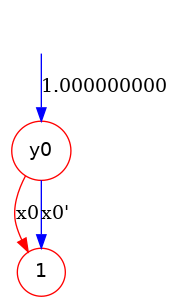

In [6]:
import qiskit
cir=qiskit.QuantumCircuit(2)
cir.x(0)
cir.draw('mpl')
tdd=simulation(cir,symbolic=True)
tdd.show()

Benchmark Name: Benchmarks/qft_5.qasm
Time: 0.020138263702392578
Qubit num.: 5
Gate num.: 15
Node num. max: 6
Node num. final: 6
gu1: 88
gu2: 46


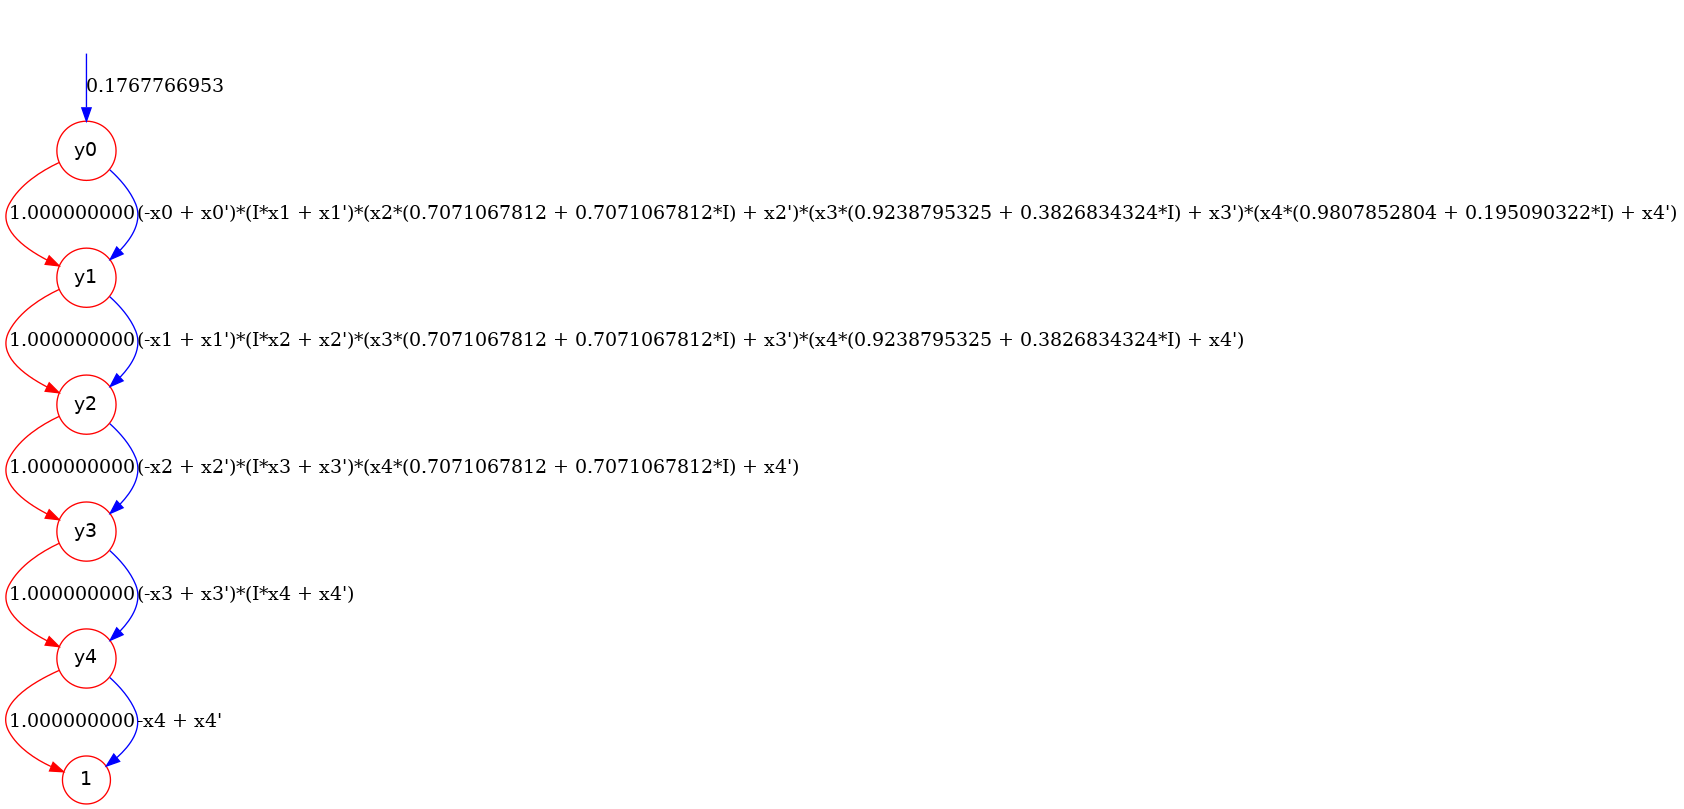

In [14]:
import os
path='Benchmarks/'
files=os.listdir(path)

tdd=simulation(path+files[0],symbolic=True)
tdd.show()
# # for i in range(len(files)):
# for i in range(5,31):

#     # print(files[i])
#     # simulation(path+files[i],symbolic=True,output_file='Simulation_Standard D8s v3.csv')
#     simulation(path+'qft_%i.qasm'%i,symbolic=True,output_file='Simulation_Standard D8s v3.csv')

#     print(i)

In [8]:
# import os
# path='Benchmarks/'
# files=os.listdir(path)

# i=0
# tdd2=Inverse_test(path+files[i])
# ,output_file='Inverse_Standard D8s v3.csv')


# for i in range(len(files)):
#     Inverse_test(path+files[i],output_file='Inverse_Standard D8s v3.csv')
#     print(i)

In [9]:
# tdd2.show()

In [10]:
# import os
# path='Benchmarks/'
# files=os.listdir(path)
# i=0

# tdd1=Fidelity_test(path+files[i])
# # ,output_file='Fidelity D8s v3.csv')
# tdd1.show()

# for i in range(len(files)):
#     Fidelity_test(path+files[i],output_file='Fidelity D8s v3.csv')
#     print(i)

In [11]:

# with open('Simulation_no_symbol_Standard D8s v3.csv', 'w', newline='') as csvfile:
#     fieldnames = ['Benchmark Name', 'Qubit num.','Gate num.','Time','Node num. max','Node num. final','gu1','gu2']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()


In [12]:

# with open('Inverse_Standard D8s v3.csv', 'w', newline='') as csvfile:
#     fieldnames = ['Benchmark Name', 'Qubit num.','Gate num.','Time','Node num. max','Node num. final','gu1','gu2']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()



In [13]:
# with open('Fidelity D8s v3.csv', 'w', newline='') as csvfile:
#     fieldnames = ['Benchmark Name', 'Qubit num.','Gate num.','Time','Node num. max','Node num. final','gu1','gu2']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
